In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import math
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot
import pandas
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

NUMERICALS = ['GIAGE1', 'HA_HEIGHT', 'HA_WEIGHT', 'TUDRPRWK', 'B1FND', 'GRS_FN', 'HA_SMOKE', 'GIERACE_1.0',
              'GIERACE_2.0', 'GIERACE_3.0', 'GIERACE_4.0', 'GIERACE_5.0', 'CLINIC_1.0','CLINIC_2.0', 'CLINIC_3.0',  
              'CLINIC_4.0', 'CLINIC_5.0', 'CLINIC_6.0','NFWLKSPD_0.0', 'NFWLKSPD_1.0', 'NFWLKSPD_2.0']


# change allele to number
def allele_to_number(sample, attribute, sig_dict):
    return sample[attribute].count(sig_dict[attribute])


# fill numerical empty cells with median of the column, race with 1 (for white) and other categorical empty cells with the 0
def fill_empty_cell(sample, attribute, data):
    if pandas.isnull(sample[attribute]):
        if attribute in NUMERICALS:
            return data[attribute].median()
        return int(attribute == 'GIERACE' )
    elif attribute == 'FRAC':
        return int(sample['FAANYSLD'] or sample['FAANYWST'] or sample['FAANYHIP'])
    return sample[attribute]


# calculate GRS
def load_weight(sheet):
    weight = []
    df = pandas.read_excel('Estrada_63.xlsx', sheet_name=sheet)
    w = list(df)[-1]
    for i in range(len(df)):
        weight.append(df.iloc[i][w])
    return weight

if __name__ == '__main__':
    data = pandas.read_excel('mros_1103snps.xlsx')
    # drop HA_SLDFXFU where only 10% is filled, drop subjectid,
    data.drop(['HA_SLDFXFU', 'TURSMOKE', 'HA_SLDFX', 'HA_WRSTFX'], axis=1, inplace=True)
    # make the fractures into 1 variable
    data['FRAC'] = 0
    for attribute in data.keys():
        data[attribute] = data.apply(lambda sample: fill_empty_cell(sample, attribute, data), axis=1)
    # drop the other fractured values
    data.drop(['FAANYSLD', 'FAANYWST', 'FAANYHIP'], axis=1, inplace=True)
    # encode the categorical data
    data = pandas.DataFrame(pandas.get_dummies(data, columns=['GIERACE', 'CLINIC', 'NFWLKSPD']))
    features = list(data)[22:-6]
    # setting Y and X
    # Y_df = np.asarray(data['B1THD'], dtype="|S8")
    Y_df = data['B1TLD']
    X_df = pandas.read_excel('ready_to_go.xlsx')
    # X_df = data.drop(['SUBJECTID', 'HA_LSD', 'B1THD', 'B1FND', 'B1TLD', 'BUAMEAN',
    #                   'FAHIPFV1', 'FASLDFV1', 'FAWSTFV1', 'EFSTATUS', 'FRAC',
    #                    'XMDSQGE1', 'XMSQGE2', 'HA_CALCIUM', 'HA_BMI'], axis=1)
    # weight_LS = load_weight('LS_sex-combined_beta')
   # feature_data = data[features]
    # weight_LS = pandas.DataFrame(pandas.Series(weight_LS, index=features, name=0))
    #weight_FN = load_weight('FN_sex-combined_beta')
    # X_df['GRS_LS'] = feature_data.dot(weight_LS)
   # X_df['GRS_FN'] = feature_data.dot(weight_FN)
   # X_df.drop(features, axis=1, inplace=True)
    # print(Y_df.shape)
    
    #X_df.to_csv('X_variables.csv')
    
    print(Y_df.head())
    print(X_df[1:1])
    print(X_df.shape)
    print(Y_df.shape)
    # save data
    with open('datamrosbmd1103_B1TLD', 'wb') as data_file_handler:
        import pickle

        pickle.dump(
            dict(
                X=X_df,
                Y=Y_df
            ),
            data_file_handler
        )


0    1.261
1    0.989
2    1.249
3    1.128
4    0.667
Name: B1TLD, dtype: float64
Empty DataFrame
Columns: [W_SCORE, GIAGE1, HA_HEIGHT, HA_WEIGHT, TUDRPRWK, QLFXST51, GIERACE_1.0, GIERACE_2.0, GIERACE_3.0, GIERACE_4.0, GIERACE_5.0, CLINIC_1.0, CLINIC_2.0, CLINIC_3.0, CLINIC_4.0, CLINIC_5.0, CLINIC_6.0, NFWLKSPD_0.0, NFWLKSPD_1.0, NFWLKSPD_2.0, HA_SMOKE_0.0, HA_SMOKE_1.0, HA_SMOKE_2.0]
Index: []

[0 rows x 23 columns]
(5130, 23)
(5130,)


In [1]:
# Linear Regression

import pickle

import numpy
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

with open('datamrosbmd1103_B1TLD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values


def linear_regression():
    model = Sequential()
    model.add(Dense(23, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
    return model


def main(plot=True):
    # fix random seed for reproducibility
    # seed = 7

    # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
    # numpy.random.seed(seed)
    # The below is necessary for starting core Python generated random numbers in a well-defined state.
    # rn.seed(seed)

    # according to keras documentation, numpy seed should be set before importing keras
    # information regarding setup for obtaining reproducible results using Keras during development in the following link https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

    # The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
    # tf.set_random_seed(seed)

    batch_size = 50
    # num_classes = 1
    # epochs = 50
    number_of_data = X.shape[0]
    number_of_train_data = int(.8 * number_of_data)
    # number_of_test_data = number_of_data - number_of_train_data

    # load dataset
    x_train, x_test = X[:number_of_train_data, :], X[number_of_train_data:, :]
    #mean_train_data = numpy.mean(train_data, axis=0)
    #std_train_data = numpy.std(train_data, axis=0)
    #x_train = (train_data - mean_train_data) / std_train_data  # mean variance normalization
    #x_test = (test_data - mean_train_data) / std_train_data  # mean variance normalization
    y_train, y_test = Y[:number_of_train_data], Y[number_of_train_data:]

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    model = linear_regression()
    # history = model.fit(x_train, y_train, batch_size=batch_size, epochs=3, verbose=1, validation_data=(x_test, y_test))
    history = model.fit(x_train, y_train, batch_size=batch_size, verbose=1, epochs=100, validation_data=(x_test, y_test))
    print(history.history.keys())
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score)

    score = model.evaluate(x_train, y_train, verbose=0)
    print('Train loss:', score)
    y_pred = model.predict(x_test)

    print('Mean Squared Error of test: ', mean_squared_error(y_test, y_pred))
    print('Mean Squared Error of train:', mean_squared_error(y_train, model.predict(x_train)))

    print('Mean Absolute Error of test: ', mean_absolute_error(y_test, y_pred))
    print('Mean Absolute Error of train: ', mean_absolute_error(y_train, model.predict(x_train)))

    print('Coefficient of Determination for test: ', r2_score(y_test, y_pred))
    print('Coefficient of Determination for train: ', r2_score(y_train, model.predict(x_train)))

        #y_test_1 = pd.Series(y_test)
    numpy.savetxt('y_test_TLBMD.csv', y_test, delimiter=',')
    
    #y_pred_1 = pd.Series(y_pred)
    #y_test_1 = pd.Series(y_test)
    numpy.savetxt('y_pred_LR_TLBMD.csv', y_pred, delimiter=',')
    
    if not plot:
        return history.history['loss'], history.history['val_loss']
    pyplot.plot(history.history['loss'], 'b-')
    pyplot.plot(history.history['val_loss'], 'r-')
    pyplot.title('Mean Squared Error Loss: Linear Regression for Total Spine BMD')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['Train Data', 'Test Data'], loc='upper right')
    pyplot.savefig('reg_B1TLD_MSE')
    pyplot.show()

    # Plot the predicted value against the actual value
    fig, ax = pyplot.subplots()
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
    pyplot.title('Scatter plot of Measured vs. Predicted : Linear Regression for Total Spine BMD')
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    pyplot.savefig('reg_B1TLD_scatter')
    pyplot.show()
    
if __name__ == '__main__':
    main()


Using TensorFlow backend.
W1108 18:06:28.044356 13948 deprecation_wrapper.py:119] From C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1108 18:06:28.054490 13948 deprecation_wrapper.py:119] From C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1108 18:06:28.057524 13948 deprecation_wrapper.py:119] From C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1108 18:06:28.072466 13948 deprecation_wrapper.py:119] From C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please

x_train shape: (4104, 23)
4104 train samples
1026 test samples
Train on 4104 samples, validate on 1026 samples
Epoch 1/100
4104/4104 [==============================] - 0s 41us/step - loss: 0.6865 - mean_squared_error: 0.6865 - mean_absolute_error: 0.7690 - val_loss: 0.1155 - val_mean_squared_error: 0.1155 - val_mean_absolute_error: 0.2817
Epoch 2/100
4104/4104 [==============================] - 0s 12us/step - loss: 0.0468 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1635 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1483
Epoch 3/100
4104/4104 [==============================] - 0s 14us/step - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1464 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1457
Epoch 4/100
4104/4104 [==============================] - 0s 12us/step - loss: 0.0362 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1445 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - v

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

0.035296146956709226  SOE


C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably mea

[0.03717092896400753, 0.03670090111876126, 0.03602949859843753, 0.03560080535218746, 0.035548048015475904, 0.035674750307374756, 0.035510627875483626, 0.03554925732002933, 0.035574272146392374, 0.035589572103456715, 0.035591475274657294, 0.03561703156959894, 0.035524205965681385, 0.03543534222504457, 0.035369494254449185, 0.03536777132056349, 0.035400300622651266, 0.03534659136647953, 0.03534421638164443, 0.035320930306135714, 0.03536495821137165, 0.035371306441240105, 0.03535029627368279, 0.035313806538393534, 0.035330963344317505, 0.03531379038643489, 0.03532343561468003, 0.035353564926554774, 0.03535120003842711, 0.03534100897994861, 0.035328485082029494, 0.035323131602725266, 0.035301564449879815, 0.03529829923396742, 0.03525747108874592, 0.035255424777059056, 0.03526221963195719, 0.03525755240002853, 0.03527339810711357, 0.035292481372995885, 0.03527671291659786, 0.03529051394468022, 0.035268769187152195, 0.03527394296085334, 0.03525848073889652, 0.03525004976277065, 0.03527206199

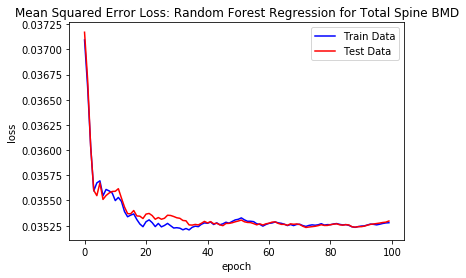

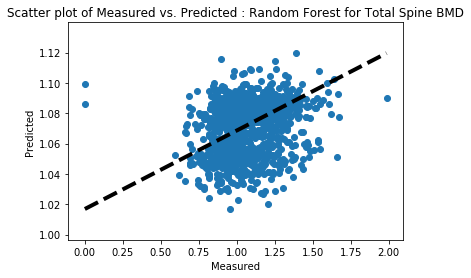

In [2]:
# Random Forest

import pickle

import numpy
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

with open('datamrosbmd1103_B1TLD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

# fix random seed for reproducibility
# seed = 7

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# numpy.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
# random.seed(seed)

# The below tensorflow.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# tensorflow.set_random_seed(seed)
# Y = label_binarize(Y, classes=[0,1])

batch_size = 120
num_classes = 2

number_of_data = X.shape[0]
number_of_train_data = int(.8 * number_of_data)
number_of_test_data = number_of_data - number_of_train_data

x_train, x_test = X[:number_of_train_data, :], X[number_of_train_data:, :]
#mean_train_data = numpy.mean(train_data, axis=0)
#std_train_data = numpy.std(train_data, axis=0)
#x_train = (train_data - mean_train_data) / std_train_data  # mean variance normalization
#x_test = (test_data - mean_train_data) / std_train_data  # mean variance normalization
y_train, y_test = Y[:number_of_train_data], Y[number_of_train_data:]

# RANDOM_STATE = 42
n_estimators = 100


# override the RandomForestRegressor library
class RandomForestRegressorCustom(RandomForestRegressor):
    def score(self, X, y, sample_weight=None):
        """Returns the coefficient of determination R^2 of the prediction.

        The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum().
        The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

        Parameters
        ----------
        X : array-like, shape = (n_samples, n_features)
            Test samples. For some estimators this may be a precomputed kernel matrix instead, shape = (n_samples, n_samples_fitted], where n_samples_fitted is the number of samples used in the fitting for the estimator.

        y : array-like, shape = (n_samples) or (n_samples, n_outputs)
            True values for X.

        sample_weight : array-like, shape = [n_samples], optional
            Sample weights.

        Returns
        -------
        score : float
            R^2 of self.predict(X) wrt. y.
        """

        return mean_squared_error(y, self.predict(X))


def create_model(epoch):
    return RandomForestRegressorCustom(n_estimators=epoch, random_state = 42, warm_start=True, oob_score=True, max_features='sqrt', max_depth=3)


def main(plot=True):
    epoch = 100
    model = create_model(epoch)
    model.fit(x_train, y_train)
    model.score(x_test, y_test)
    print(model.score(x_test, y_test), ' SOE')

    train_score, test_score = [], []

    for i in range(epoch):
        model = create_model(i + 1)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
    print(test_score, ' TEST SCORE')
    print(train_score, ' TRAIN SCORE')

    print('Mean Square Error of test: ', mean_squared_error(y_test, model.predict(x_test)))
    print('Mean Square Error of train: ', mean_squared_error(y_train, model.predict(x_train)))
    
    print('Mean Absolute Error of test: ', mean_absolute_error(y_test, model.predict(x_test))) 
    print('Mean Absolute Error of train: ', mean_absolute_error(y_train, model.predict(x_train)))
    
    print('Coefficient of Determination for test: ', r2_score(y_test, model.predict(x_test)))
    print('Coefficient of Determination for train: ', r2_score(y_train, model.predict(x_train)))

    if not plot:
        return train_score, test_score
    pyplot.plot(range(epoch), train_score, 'b-')
    pyplot.plot(range(epoch), test_score, 'r-')
    pyplot.title('Mean Squared Error Loss: Random Forest Regression for Total Spine BMD')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['Train Data', 'Test Data'], loc='upper right')
    pyplot.savefig('rf_B1TLD_MSE')
    pyplot.show()
    
    y_pred = model.predict(x_test)
    numpy.savetxt('y_pred_RF_TLBMD.csv', y_pred, delimiter=',')
    
    # Plot the predicted value against the actual value
    fig, ax = pyplot.subplots()
    ax.scatter(y_test, model.predict(x_test))
    ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
    pyplot.title('Scatter plot of Measured vs. Predicted : Random Forest for Total Spine BMD')
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    pyplot.savefig('rf_B1TLD_scatter')
    pyplot.show()

if __name__ == '__main__':
    main()


C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of

[-0.02014224 -0.02700022 -0.06048521]  ALL TRY


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished


[0.1971902  0.11047369 0.17583668 0.22586295 0.08900015 0.0377257
 0.0069824  0.00943141 0.00383871 0.00392039 0.00149714 0.01625732
 0.01498992 0.01167692 0.01838884 0.01856052 0.01404387 0.00292901
 0.00597265 0.00509273 0.01252981 0.01327908 0.0045199 ]
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=35,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=1, warm_start=False)  HISTORY
Mean Square Error of test:  0.03494169285886133
Mean Square Error of train:  0.034666572812081735
Mean Absolute Error of test:  0.14752032859927597
Mean Absolute Error of train:  0.05609505012531327
Coefficient of Determination for test:  0.04014594778270286
Coefficient 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished


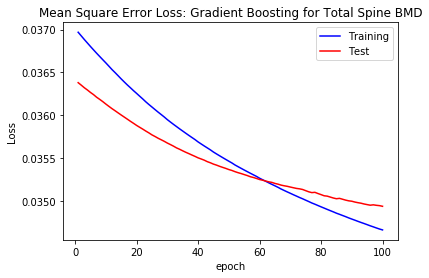

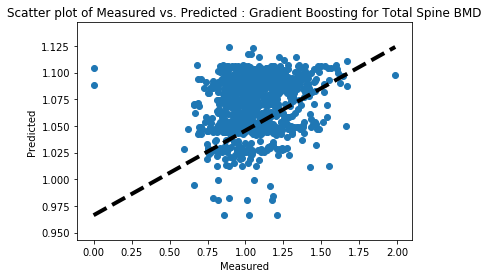

In [3]:
# Gradient Boosting

import pickle
from matplotlib import pyplot
import numpy

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

with open('datamrosbmd1103_B1TLD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values


def create_model():
    return RandomForestRegressor(n_estimators=35, verbose=1)


def main(plot=True):
    # fix random seed for reproducibility
    # seed = 7
    # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
    # numpy.random.seed(seed)
    # The below is necessary for starting core Python generated random numbers in a well-defined state.
    # random.seed(seed)

    # The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
    # tf.set_random_seed(seed)
    # Y = label_binarize(Y, classes=[0,1])

    # batch_size = 120
    # num_classes = 2
    # epochs = 15

    number_of_data = X.shape[0]
    number_of_train_data = int(.8 * number_of_data)
    # number_of_test_data = number_of_data - number_of_train_data

    # load dataset for MLP
    x_train, x_test = X[:number_of_train_data, :], X[number_of_train_data:, :]
    #mean_train_data = numpy.mean(train_data, axis=0)
    #std_train_data = numpy.std(train_data, axis=0)
    #x_train = (train_data - mean_train_data) / std_train_data  # mean variance normalization
    #x_test = (test_data - mean_train_data) / std_train_data  # mean variance normalization
    y_train, y_test = Y[:number_of_train_data], Y[number_of_train_data:]

    model = create_model()

    validatescores = cross_val_score(model, x_train, y_train)
    print(validatescores, ' ALL TRY')

    history = model.fit(x_train, y_train)
    print(history.feature_importances_)
    print(history, ' HISTORY')
    # y_pred = model.predict(x_test)

    params = {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
    gbr = GradientBoostingRegressor(**params)
    gbr.fit(x_train, y_train)

    test_score = numpy.zeros((params['n_estimators'],), dtype=numpy.float64)
    mse = mean_squared_error(y_test, gbr.predict(x_test))

    print('Mean Square Error of test: ', mean_squared_error(y_test, gbr.predict(x_test)))
    print('Mean Square Error of train: ', mean_squared_error(y_train, gbr.predict(x_train)))

    print('Mean Absolute Error of test: ', mean_absolute_error(y_test, model.predict(x_test)))
    print('Mean Absolute Error of train: ', mean_absolute_error(y_train, model.predict(x_train)))
    
    print('Coefficient of Determination for test: ', r2_score(y_test, gbr.predict(x_test)))
    print('Coefficient of Determination for train: ', r2_score(y_train, gbr.predict(x_train)))
    
    y_pred = gbr.predict(x_test)
    numpy.savetxt('y_pred_GB_TLBMD.csv', y_pred, delimiter=',')
    
    for i, y_pred in enumerate(gbr.staged_predict(x_test)):
        test_score[i] = gbr.loss_(y_test, y_pred)
    if not plot:
        return gbr.train_score_, test_score
    pyplot.figure()
    pyplot.title('Mean Square Error Loss: Gradient Boosting for Total Spine BMD')
    pyplot.plot(numpy.arange(params['n_estimators']) + 1, gbr.train_score_, 'b-', label='Training')
    pyplot.plot(numpy.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test')
    pyplot.legend(loc='upper right')
    pyplot.legend(loc='upper right')
    pyplot.xlabel('epoch')
    pyplot.ylabel('Loss')
    pyplot.savefig('gb_B1TLD_MSE')
    pyplot.show()

    # Plot the predicted value against the actual value
    fig, ax = pyplot.subplots()
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
    pyplot.title('Scatter plot of Measured vs. Predicted : Gradient Boosting for Total Spine BMD')
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    pyplot.savefig('gb_B1TLD_scatter')
    pyplot.show()


if __name__ == '__main__':
    main()


x_train shape: (4104, 23)
4104 train samples
1026 test samples
Train on 4104 samples, validate on 1026 samples
Epoch 1/100
4104/4104 [==============================] - 0s 53us/step - loss: 0.6079 - mean_squared_error: 0.6079 - mean_absolute_error: 0.6725 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1650
Epoch 2/100
4104/4104 [==============================] - 0s 14us/step - loss: 0.0379 - mean_squared_error: 0.0379 - mean_absolute_error: 0.1484 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1467
Epoch 3/100
4104/4104 [==============================] - 0s 13us/step - loss: 0.0368 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1461 - val_loss: 0.0355 - val_mean_squared_error: 0.0355 - val_mean_absolute_error: 0.1457
Epoch 4/100
4104/4104 [==============================] - 0s 12us/step - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1454 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - v

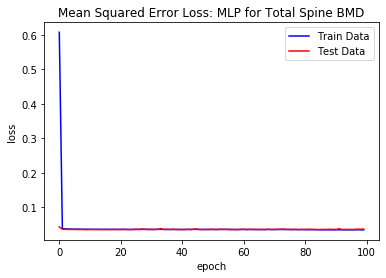

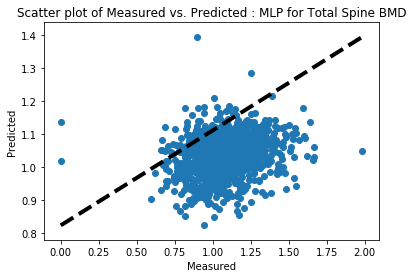

In [5]:
# MLP

import pickle

import numpy
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense

with open('datamrosbmd1103_B1TLD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values


def mlp():
    model = Sequential()
    model.add(Dense(30, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, input_dim=10, kernel_initializer='normal', activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
    return model


def main(plot=True):
    # fix random seed for reproducibility
    # seed = 7

    # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
    # numpy.random.seed(seed)
    # The below is necessary for starting core Python generated random numbers in a well-defined state.
    # rn.seed(seed)

    # according to keras documentation, numpy seed should be set before importing keras information regarding setup for obtaining reproducible results using Keras during development in the following link https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

    # The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
    # tf.set_random_seed(seed)

    batch_size = 50
    # num_classes = 1
    # epochs = 50
    number_of_data = X.shape[0]
    number_of_train_data = int(.8 * number_of_data)
    # number_of_test_data = number_of_data - number_of_train_data

    # load dataset
    x_train, x_test = X[:number_of_train_data, :], X[number_of_train_data:, :]
    #mean_train_data = numpy.mean(train_data, axis=0)
    #std_train_data = numpy.std(train_data, axis=0)
    #x_train = (train_data - mean_train_data) / std_train_data  # mean variance normalization
    #x_test = (test_data - mean_train_data) / std_train_data  # mean variance normalization
    y_train, y_test = Y[:number_of_train_data], Y[number_of_train_data:]

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    model = mlp()
    # history = model.fit(x_train, y_train, batch_size=batch_size, epochs=3, verbose=1, validation_data=(x_test, y_test))
    history = model.fit(x_train, y_train, batch_size=batch_size, verbose=1, epochs=100, validation_data=(x_test, y_test))
    print(history.history.keys())
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score)

    score = model.evaluate(x_train, y_train, verbose=0)
    print('Train loss:', score)
    y_pred = model.predict(x_test)
    numpy.savetxt('y_pred_MLP_TLBMD.csv', y_pred, delimiter=',')
    
    print('Mean Squared Error of test: ', mean_squared_error(y_test, y_pred))
    print('Mean Squared Error of train: ', mean_squared_error(y_train, model.predict(x_train)))

    print('Mean Absolute Error of test: ', mean_absolute_error(y_test, y_pred))
    print('Mean Absolute Error of train: ', mean_absolute_error(y_train, model.predict(x_train)))

    print('Coefficient of Determination for test: ', r2_score(y_test, y_pred))
    print('Coefficient of Determination for train: ', r2_score(y_train, model.predict(x_train)))

    if not plot:
        return history.history['loss'], history.history['val_loss']
    pyplot.plot(history.history['loss'], 'b-')
    pyplot.plot(history.history['val_loss'], 'r-')
    pyplot.title('Mean Squared Error Loss: MLP for Total Spine BMD')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['Train Data', 'Test Data'], loc='upper right')
    pyplot.savefig('mlp_B1TLD_MSE')
    pyplot.show()
    
    # Plot the predicted value against the actual value
    fig, ax = pyplot.subplots()
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
    pyplot.title('Scatter plot of Measured vs. Predicted : MLP for Total Spine BMD')
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    pyplot.savefig('mlp_B1TLD_scatter')
    pyplot.show()

if __name__ == '__main__':
    main()


In [10]:
# Testing of regression ML model by using 5 * 2 cv paired t test for linear vs. random forest

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from mlxtend.evaluate import paired_ttest_5x2cv

with open('datamrosbmd1103_B1TLD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=linear,
                          estimator2=rf,
                          X=X, y=Y,
                          random_seed=1)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


t statistic: 4.83353
p avlue: 0.00474


In [11]:
# Testing of regression ML model by using 5 * 2 cv paired t test for linear vs. gb

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from mlxtend.evaluate import paired_ttest_5x2cv

with open('datamrosbmd1103_B1TLD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=linear,
                          estimator2=gb,
                          X=X, y=Y,
                          random_seed=2)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

t statistic: -0.44424
p avlue: 0.67544


In [14]:
# Testing of regression ML model by using 5 * 2 cv paired t test for rf vs. gb

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from mlxtend.evaluate import paired_ttest_5x2cv

with open('datamrosbmd1103_B1TLD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=rf,
                          estimator2=gb,
                          X=X, y=Y,
                          random_seed=1)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


t statistic: -5.94590
p avlue: 0.00192


In [20]:
# Testing of regression ML model by using 5 * 2 cv paired t test for linear vs. mlp

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from mlxtend.evaluate import paired_ttest_5x2cv

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score
from keras import optimizers

with open('datamrosbmd1103_B1TLD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

def mlp():
    model = Sequential()
    model.add(Dense(30, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, input_dim=10, kernel_initializer='normal', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

mlp = mlp()
linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=linear,
                          estimator2=mlp,
                          X=X, y=Y,
                          random_seed=2)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

Epoch 1/1
2565/2565 [==============================] - 0s 113us/step - loss: 0.5490
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0383
Epoch 1/1
2565/2565 [==============================] - 0s 18us/step - loss: 0.0383
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0354
Epoch 1/1
2565/2565 [==============================] - 0s 18us/step - loss: 0.0353
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0370
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0356
Epoch 1/1
2565/2565 [==============================] - 0s 18us/step - loss: 0.0361
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0377
Epoch 1/1
2565/2565 [==============================] - 0s 18us/step - loss: 0.0345
t statistic: 4.27916
p avlue: 0.00787


In [28]:
# Testing of regression ML model by using 5 * 2 cv paired t test for rf vs. mlp

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from mlxtend.evaluate import paired_ttest_5x2cv

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score
from keras import optimizers
def mlp():
    model = Sequential()
    model.add(Dense(30, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, input_dim=10, kernel_initializer='normal', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

mlp = mlp()
linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=rf,
                          estimator2=mlp,
                          X=X, y=Y,
                          random_seed=2)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Epoch 1/1
2565/2565 [==============================] - 0s 188us/step - loss: 0.7083
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0411
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0376
Epoch 1/1
2565/2565 [==============================] - 0s 23us/step - loss: 0.0356
Epoch 1/1
2565/2565 [==============================] - 0s 23us/step - loss: 0.0348
Epoch 1/1
2565/2565 [==============================] - 0s 23us/step - loss: 0.0369
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0355
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0360
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0373
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0340
t statistic: 2.47327
p avlue: 0.05630


In [30]:
# Testing of regression ML model by using 5 * 2 cv paired t test for gb vs. mlp

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense

from mlxtend.evaluate import paired_ttest_5x2cv

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score
from keras import optimizers
def mlp():
    model = Sequential()
    model.add(Dense(30, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, input_dim=10, kernel_initializer='normal', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

mlp = mlp()
linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=gb,
                          estimator2=mlp,
                          X=X, y=Y,
                          random_seed=2)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

Epoch 1/1
2565/2565 [==============================] - 1s 206us/step - loss: 0.6300
Epoch 1/1
2565/2565 [==============================] - 0s 22us/step - loss: 0.0381
Epoch 1/1
2565/2565 [==============================] - 0s 22us/step - loss: 0.0375
Epoch 1/1
2565/2565 [==============================] - 0s 24us/step - loss: 0.0353
Epoch 1/1
2565/2565 [==============================] - 0s 23us/step - loss: 0.0351
Epoch 1/1
2565/2565 [==============================] - 0s 22us/step - loss: 0.0371
Epoch 1/1
2565/2565 [==============================] - 0s 22us/step - loss: 0.0358
Epoch 1/1
2565/2565 [==============================] - 0s 22us/step - loss: 0.0362
Epoch 1/1
2565/2565 [==============================] - 0s 23us/step - loss: 0.0373
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0343
t statistic: 3.25467
p avlue: 0.02258
